# A tour of the ComPert model

In [1]:
import sys
sys.path.append("../")

In [2]:
# some standard packages to assist this tutorial
from pprint import pprint

In [3]:
from compert.train import train_compert
from compert.data import load_dataset_splits
from compert.plotting import CompertVisuals
from compert.api import ComPertAPI
import pandas as pd


# Training your model

You can specify all the parameters for the model in a dictionary of parameters. If they are not specified, default values will be selected.

`autoencoder_params` are technical parameters of the architecture of the autoencoder. 

In [4]:
autoencoder_params = { 'adversary_depth': 4,
                          'adversary_lr': 0.0001875455179637405,
                          'adversary_steps': 3,
                          'adversary_wd': 0.00019718137187038062,
                          'adversary_width': 256,
                          'autoencoder_depth': 4,
                          'autoencoder_lr': 0.0011021870411382655,
                          'autoencoder_wd': 1.1455862519513426e-05,
                          'autoencoder_width': 256,
                          'batch_size': 128,
                          'dim': 256,
                          'dosers_depth': 2,
                          'dosers_lr': 0.00026396192072937485,
                          'dosers_wd': 7.165810318386074e-07,
                          'dosers_width': 32,
                          'penalty_adversary': 8.735507132389051,
                          'reg_adversary': 69.6011204833175,
                          'step_size_lr': 25}

In `args` you need to specify the main parameters related to training. 

In [5]:
args = {'dataset_path': '../datasets/GSM_new.h5ad', # full path to the anndata dataset 
        'cell_type_key': 'cell_type', # necessary field for cell types. Fill it with a dummy variable if no celltypes present.
        'split_key': 'split', # necessary field for train, test, ood splits.
        'perturbation_key': 'condition', # necessary field for perturbations
        'dose_key': 'dose_val', # necessary field for dose. Fill in with dummy variable if dose is the same. 
        'checkpoint_freq': 20, # checkoint frequencty to save intermediate results
        'hparams': autoencoder_params, # autoencoder architecture
        'max_epochs': 5, # maximum epochs for training
        'max_minutes': 60, # maximum computation time
        'patience': 20, # patience for early stopping
        'loss_ae': 'gauss', # loss (currently only gaussian loss is supported)
        'doser_type': 'sigm', # non-linearity for doser function
        'save_dir': './', # directory to save the model
        'decoder_activation': 'linear', # last layer of the decoder
        'seed': 0, # random seed
        'sweep_seeds': 0}

IMPORTANT. Currenlty because of the standartized evaluation procedure, we need to provide adata.obs['control'] (0 if not control, 1 for cells to use as control). And we also need to provide de_genes in .uns['rank_genes_groups']. This genes corresond to the groups of drugs in adata.obs['drug_dose_name']. adata.obs['drug_dose_name'] is a neccessary field to standartized evaluation even for the datasets that don't have doses.

# Training and predicting with ComPert models

We are showing an example with only 5 epochs, but you can modify this parameter in args. 

In [6]:
autoencoder, datasets = train_compert(args, return_model=True)

{"training_args": {"dataset_path": "../datasets/GSM_new.h5ad", "cell_type_key": "cell_type", "split_key": "split", "perturbation_key": "condition", "dose_key": "dose_val", "checkpoint_freq": 20, "hparams": {"adversary_depth": 4, "adversary_lr": 0.0001875455179637405, "adversary_steps": 3, "adversary_wd": 0.00019718137187038062, "adversary_width": 256, "autoencoder_depth": 4, "autoencoder_lr": 0.0011021870411382655, "autoencoder_wd": 1.1455862519513426e-05, "autoencoder_width": 256, "batch_size": 128, "dim": 256, "dosers_depth": 2, "dosers_lr": 0.00026396192072937485, "dosers_wd": 7.165810318386074e-07, "dosers_width": 32, "penalty_adversary": 8.735507132389051, "reg_adversary": 69.6011204833175, "step_size_lr": 25}, "max_epochs": 5, "max_minutes": 60, "patience": 20, "loss_ae": "gauss", "doser_type": "sigm", "save_dir": "./", "decoder_activation": "linear", "seed": 0, "sweep_seeds": 0}}
{"autoencoder_params": {"dim": 256, "dosers_width": 32, "dosers_depth": 2, "dosers_lr": 0.0002639619

## Or loading pre-trained model

This part is optional if you want to load pre-trained model. The name of the file where the model was saved appears as the last line of the output the train_compert().

In [8]:
import torch
from compert.train import prepare_compert

model_name = '../pretrained_models/GSM/sweep_GSM_new_logsigm_model_seed=60_epoch=1120.pt'
state, args, history = torch.load(model_name, map_location=torch.device('cpu'))
args['dataset_path'] = '../datasets/GSM_new.h5ad'

# load the dataset and model pre-trained weights
autoencoder, datasets = prepare_compert(args, state_dict=state)

# History

In [9]:
from compert.plotting import ComPertHistory
pretty_history = ComPertHistory(history)

In [10]:
pretty_history.print_time()

Computation time: 64 min


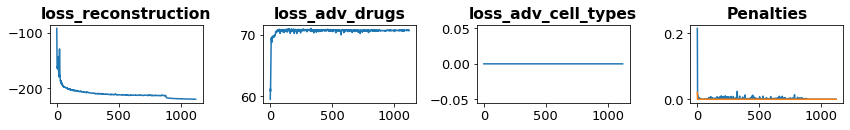

In [11]:
pretty_history.plot_losses()

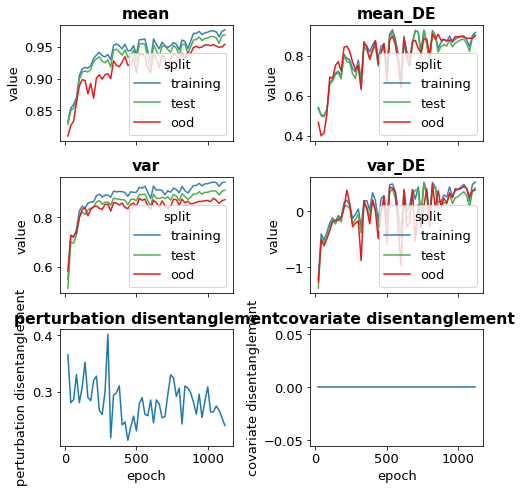

In [12]:
pretty_history.plot_metrics(epoch_min=0)

In [13]:
from compert.train import evaluate

# ComPert API for compatibility with scanpy

In [14]:
compert_api = ComPertAPI(datasets, autoencoder)

Print and plot drug embeddings.

In [15]:
perts_anndata = compert_api.get_drug_embeddings()
perts_anndata

AnnData object with n_obs × n_vars = 5 × 256
    obs: 'condition'

Print and plot covars embeddings.

In [16]:
covars_anndata = compert_api.get_covars_embeddings()
covars_anndata

AnnData object with n_obs × n_vars = 1 × 256
    obs: 'cell_type'

In [17]:
compert_api.num_measured_points['training']

{'A549_BMS_0.001': 442,
 'A549_BMS_0.005': 391,
 'A549_BMS_0.01': 262,
 'A549_BMS_0.05': 134,
 'A549_BMS_0.1': 103,
 'A549_BMS_1.0': 13,
 'A549_Dex_0.001': 204,
 'A549_Dex_0.005': 264,
 'A549_Dex_0.01': 479,
 'A549_Dex_0.05': 484,
 'A549_Dex_0.1': 486,
 'A549_Dex_1.0': 568,
 'A549_Nutlin_0.001': 284,
 'A549_Nutlin_0.005': 252,
 'A549_Nutlin_0.01': 387,
 'A549_Nutlin_0.05': 350,
 'A549_Nutlin_0.1': 457,
 'A549_Nutlin_1.0': 6,
 'A549_SAHA_0.001': 392,
 'A549_SAHA_0.005': 376,
 'A549_SAHA_0.01': 383,
 'A549_SAHA_0.05': 299,
 'A549_SAHA_0.1': 297,
 'A549_SAHA_1.0': 282,
 'A549_Vehicle_1.0': 1535}

In [18]:
compert_api.compute_comb_emb(thrh=0)
compert_api.compute_uncertainty(
                    cov='A549', 
                    pert='Nutlin', 
                    dose='1.0'
                )

(5.9604645e-08, 5.268356e-09, 'A549_Nutlin_1.0', 'A549_Nutlin_1.0')

In [19]:
compert_api.measured_points['training']

{'A549': {'BMS': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Dex': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Nutlin': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'SAHA': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Vehicle': [1.0]}}

In [20]:
compert_api

Setting up a variable for automatic plotting. The plots also could be used separately.

In [21]:
compert_plots = CompertVisuals(compert_api, fileprefix=None)

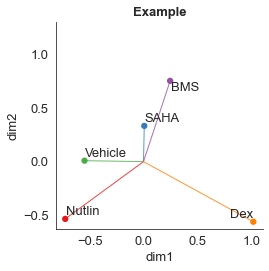

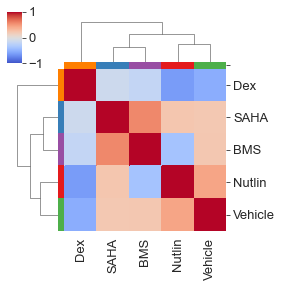

In [22]:
compert_plots.plot_latent_embeddings(compert_api.emb_perts, kind='perturbations', show_text=True)

If your have a lot of cell types or a lot of perturbations, you can also chose to not display their names.

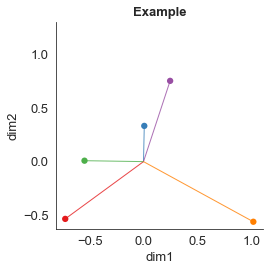

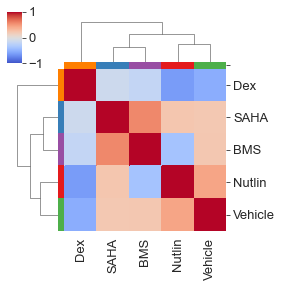

In [23]:
compert_plots.plot_latent_embeddings(compert_api.emb_perts, kind='perturbations', show_text=False)

Or I can change the color scheme for the emebddings.

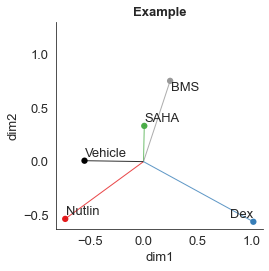

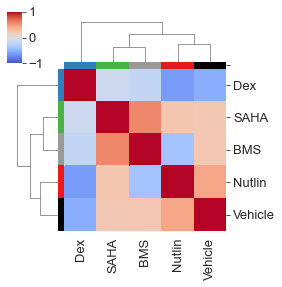

In [24]:
perts_palette = {'BMS': '#999999',                 
                 'SAHA': '#4daf4a',
                 'Dex': '#377eb8',
                 'Nutlin': '#e41a1c',
                 'Vehicle': '#000000'
    
                }

compert_plots.perts_palette = perts_palette
compert_plots.plot_latent_embeddings(compert_api.emb_perts, kind='perturbations', show_text=True)

In [25]:
compert_plots.plot_latent_embeddings(compert_api.emb_covars, kind='covars')

Embedding contains only 1 vectors. Not enough to plot.


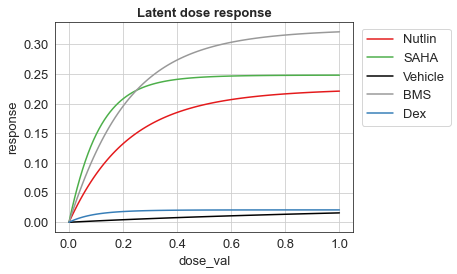

In [26]:
latent_response = compert_api.latent_dose_response(perturbations=None)
compert_plots.plot_contvar_response(
    latent_response, 
    postfix='latent',
    var_name=compert_api.perturbation_key,
    title_name='Latent dose response')

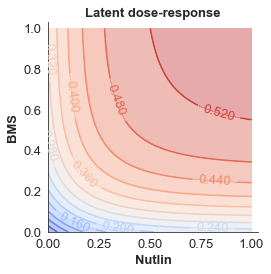

In [27]:
perturbations_pair = ['Nutlin', 'BMS']
latent_dose_2D = compert_api.latent_dose_response2D(perturbations_pair, n_points=100)
compert_plots.plot_contvar_response2D(latent_dose_2D, 
        title_name='Latent dose-response')


CPU times: user 30.5 s, sys: 1.26 s, total: 31.7 s
Wall time: 31 s


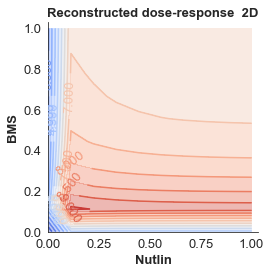

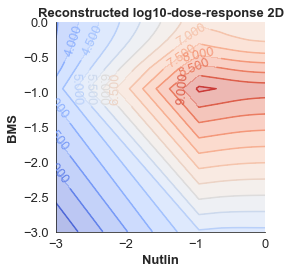

In [28]:
%%time
reconstructed_response2D = compert_api.get_response2D(datasets, perturbations_pair, compert_api.unique_сovars[0])
compert_plots.plot_contvar_response2D(reconstructed_response2D,
                                              title_name='Reconstructed dose-response  2D',
                                              logdose=False,
                                              # xlims=(-3, 0), ylims=(-3, 0)
                                              )

compert_plots.plot_contvar_response2D(reconstructed_response2D,
                                      title_name='Reconstructed log10-dose-response 2D',
                                      logdose=True,
                                      xlims=(-3, 0), ylims=(-3, 0)
                                      )

If you want to plot in on a log scale, you can just log values in the data frame.

In [29]:
# %%time
df_reference = compert_api.get_response_reference(datasets)        

In [30]:
# %%time
reconstructed_response = compert_api.get_response(datasets)

You can plot an average response (saved under "response" column) among all genes, however, we don't consider it to be a good metric and strongly advise to look at the individual response among DE genes.

Solid lines in this plot correspond to the model predictions, dashed lines -- linear interpolations between measured points. Dots represent measured points, their color is proportional to the number of cells in this condition. Black dots represent points used in training and red dots correspond to the out-of-distribution examples.

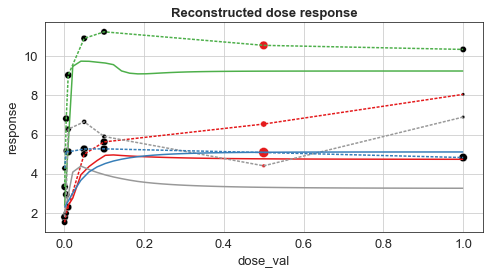

In [31]:
df_reference = df_reference.replace('training_treated', 'train')
compert_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference, 
    postfix='reconstructed',
    title_name='Reconstructed dose response')

For example we can take of the top 50 DE genes for Nutlin - MDM2. MDM2 is itself transcriptionally-regulated by p53. And p53 is the target of Nutlin. Therefore, we expect our model to learn it.

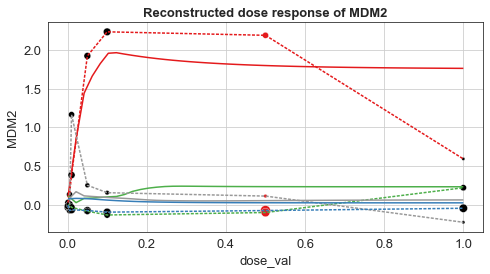

In [32]:
compert_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference,
    response_name='MDM2',
    postfix='MDM2',
    title_name='Reconstructed dose response of MDM2')

We can also look at this plot on the log10-scale. It makes sense for this dataset, because the measured doses were not evenly distributed.

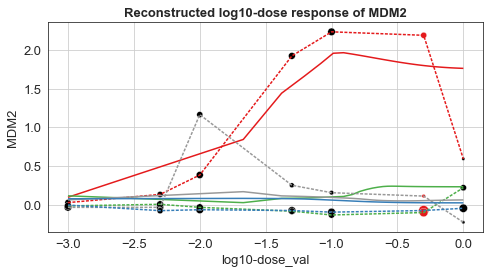

In [33]:
compert_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference,
    response_name='MDM2',
    postfix='MDM2',
    logdose=True,
    title_name='Reconstructed log10-dose response of MDM2')

# Predictions

In [34]:
print('Perturbations:', compert_api.unique_perts)
print('Covariates:', compert_api.unique_сovars)
print('Datasets splits:', datasets.keys())

Perturbations: ['Nutlin', 'SAHA', 'Vehicle', 'BMS', 'Dex']
Covariates: ['A549']
Datasets splits: dict_keys(['training', 'training_control', 'training_treated', 'test', 'test_control', 'test_treated', 'ood'])


We can chose control cells from which we want to make our predictions. It is easy to chose these cells from either training or test splits.

In [35]:
genes_control = datasets['test_control'].genes

In [36]:
df = pd.DataFrame({args['perturbation_key']: ['BMS', 'Dex'], 
                   args['dose_key']: ['1.0', '0.5'], 
                   args['cell_type_key']: ['A549', 'A549']})

By default, the prediction function returns means and variances of the applied perturbations. 

In [37]:
%%time
compert_api.predict(genes_control, df, return_anndata=True)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


CPU times: user 3.46 s, sys: 206 ms, total: 3.67 s
Wall time: 3.5 s


AnnData object with n_obs × n_vars = 1240 × 4999
    obs: 'condition', 'dose_val', 'cell_type', 'uncertainty_cosine', 'uncertainty_euclidean', 'closest_cond_cosine', 'closest_cond_euclidean'
    layers: 'variance'

By default, the prediction function returns means and variances of the applied perturbations. 

In [38]:
anndata_predicted = compert_api.predict(genes_control, df, return_anndata=True, sample=False)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


However, in some cases you want to sample from this distribution, so you can explicitly specify it in the predict function.

In [39]:
anndata_predicted_samples = compert_api.predict(genes_control, df, return_anndata=True, sample=True, n_samples=10)

Careful! These are sampled values! Better use means and                 variances for dowstream tasks!


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


# Evaluation

In [40]:
genes_control = datasets['training_control'].genes
df_train = compert_api.evaluate_r2(datasets['training_treated'], genes_control)
df_train['benchmark'] = 'CPA'

In [41]:
genes_control = datasets['test_control'].genes
df_ood = compert_api.evaluate_r2(datasets['ood'], genes_control)
df_ood['benchmark'] = 'CPA'

In [42]:
genes_control = datasets['test_control'].genes
df_test = compert_api.evaluate_r2(datasets['test_treated'], genes_control)
df_test['benchmark'] = 'CPA'

In [43]:
df_test = compert_api.evaluate_r2(datasets['test_treated'], genes_control)
df_test['benchmark'] = 'CPA'

In [44]:
df_ood['split'] = 'ood'
df_test['split'] ='test'
df_train['split'] ='train'

In [45]:
df_score = pd.concat([df_train, df_test, df_ood])
df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE'], ascending=False)

,cell_type,condition,dose_val,R2_mean,R2_mean_DE,R2_var,R2_var_DE,num_cells,benchmark,split
19,A549,SAHA,0.005,0.99,0.99,0.97,0.91,376,CPA,train
20,A549,SAHA,0.01,0.99,0.99,0.95,0.86,160,CPA,test
20,A549,SAHA,0.01,0.99,0.98,0.97,0.90,383,CPA,train
19,A549,SAHA,0.005,0.98,0.98,0.93,0.88,143,CPA,test
18,A549,SAHA,0.001,0.98,0.96,0.95,0.58,392,CPA,train
21,A549,SAHA,0.05,0.98,0.95,0.93,0.83,118,CPA,test
23,A549,SAHA,1.0,0.98,0.95,0.91,0.64,137,CPA,test
23,A549,SAHA,1.0,0.98,0.94,0.93,0.60,282,CPA,train
21,A549,SAHA,0.05,0.98,0.92,0.96,0.84,299,CPA,train
18,A549,SAHA,0.001,0.97,0.97,0.92,0.48,169,CPA,test


In [46]:
cols_print = ['condition', 'dose_val','R2_mean', 'R2_mean_DE', 'R2_var', 'R2_var_DE', 'split', 'num_cells']
df_score = df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE'], ascending=False)
print(df_score[cols_print])
# print(df_score[cols_print].to_latex(index=False))

   condition dose_val  R2_mean  R2_mean_DE  R2_var  R2_var_DE  split num_cells
19      SAHA    0.005     0.99        0.99    0.97       0.91  train       376
20      SAHA     0.01     0.99        0.99    0.95       0.86   test       160
20      SAHA     0.01     0.99        0.98    0.97       0.90  train       383
19      SAHA    0.005     0.98        0.98    0.93       0.88   test       143
18      SAHA    0.001     0.98        0.96    0.95       0.58  train       392
21      SAHA     0.05     0.98        0.95    0.93       0.83   test       118
23      SAHA      1.0     0.98        0.95    0.91       0.64   test       137
23      SAHA      1.0     0.98        0.94    0.93       0.60  train       282
21      SAHA     0.05     0.98        0.92    0.96       0.84  train       299
18      SAHA    0.001     0.97        0.97    0.92       0.48   test       169
22      SAHA      0.1     0.97        0.87    0.95       0.79  train       297
22      SAHA      0.1     0.96        0.86    0.94  

# Uncertainty

We can profile all the predictions with an uncertainty score. Low uncertainty means "good/trustworthy" predictions, high values mean "bad/unknown quality" predictions.

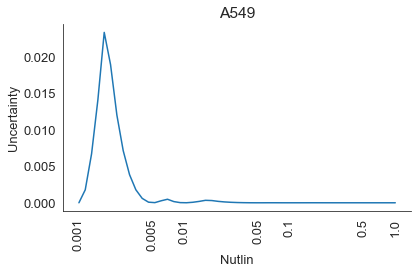

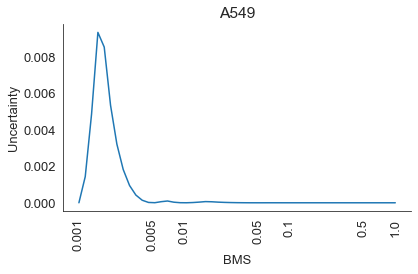

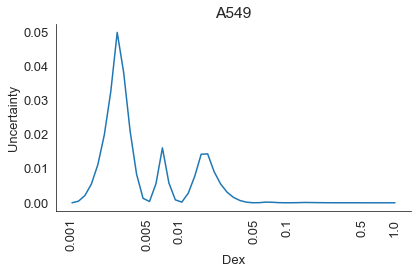

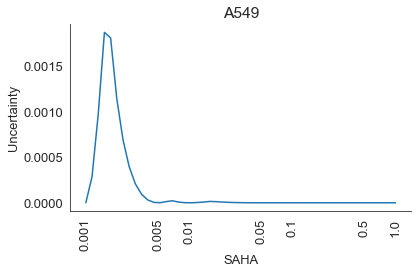

In [47]:
import compert.plotting as pl

for drug in ['Nutlin', 'BMS', 'Dex', 'SAHA']:
    df_pred = pl.plot_uncertainty_dose(
        compert_api,
        cov='A549',
        pert=drug,
        N=51,
        measured_points=compert_api.measured_points['all'],
        cond_key='condition',
        log=True,
        metric='cosine'
    )

Previously, we demonstrated CPA predictions for drugs combinations. But our training data didn't contain any combinations examples. How much can we trust these examples? We can try to asses by running model uncertainty predictions:

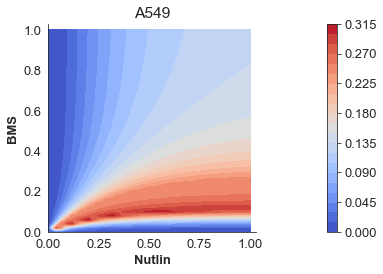

In [48]:
df_pred2D = pl.plot_uncertainty_comb_dose(
    compert_api=compert_api,
    cov='A549',
    pert='Nutlin+BMS',
    N=51,
    cond_key='treatment',
    metric='cosine',
)

And here is the predicted response we plotted before:

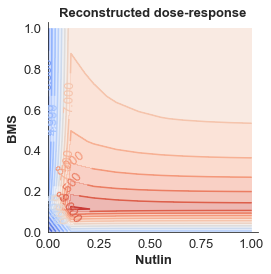

In [49]:
compert_plots.plot_contvar_response2D(reconstructed_response2D, 
    title_name='Reconstructed dose-response', logdose=False)

And now keep in mind, that the highest uncertainty for OOD cases (for which we know that their predictions were fairly good) is 0.002:

In [50]:
df_pred['uncertainty_cosine'].max().round(3)

0.002

Therefore, be careful with interpreting drug combinations in this dataset!

In [51]:
compert_api.measured_points['training']['A549']['Nutlin']

[0.001, 0.005, 0.01, 0.05, 0.1, 1.0]